In [1]:
import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

In [2]:
current_file_dir = os.getcwd()


In [19]:
train_results_json="../out_evaluate_patch/train_scores_patch.json"
val_results_json="../out_evaluate_patch/val_scores_patch.json"
train_results_json=os.path.join(current_file_dir,train_results_json)    
val_results_json=os.path.join(current_file_dir,val_results_json)    




def create_tables(train_data,clases):
    labels=[]
    preds=[]
    filenames=[]
    for d in train_data:
        truth=[]
        pred=[]
        gt=d['ground_truth']
        scores=d['scores']
        d['filename']
        for defecto in clases:
            truth.append(gt[defecto])
            pred.append(scores[defecto])
        labels.append(truth)
        preds.append(pred)
        filenames.append(d['filename'])
            
    labels=torch.tensor(labels)
    preds=torch.tensor(preds)

    return preds,labels,filenames


with open(train_results_json, "r") as f:
    train_dict = json.load(f)

with open(val_results_json, "r") as f:
    val_dict = json.load(f)    

train_data=train_dict['train_results']
val_data = val_dict['val_results']
clases=list(train_dict['train_results'][0]['ground_truth'].keys())

print(len(train_data))
print(len(val_data))

1052
279


In [21]:
preds_train,labels_train,filenames_train=create_tables(train_data,clases)
preds_val,labels_val,filenames_val=create_tables(val_data,clases)
print(len(filenames_train))

1052


# Cantidad de muestras de con cada defecto

In [5]:
print("==========================================")
print("  ** VAL **")
print("==========================================")

n_por_defecto=labels_val.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_val.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_val.shape[0])

print("\n==========================================")
print("  ** TRAIN **")
print("==========================================")

n_por_defecto=labels_train.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_train.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_train.shape[0])

  ** VAL **
green : 10
hollow : 7
insect : 3
light_scars : 26
oil_spots : 18
plu_stickers : 9
rotten : 17
scars : 18
skin_breakdown : 16
surface : 81
N sin defectos: 119
N total: 279

  ** TRAIN **
green : 54
hollow : 26
insect : 4
light_scars : 98
oil_spots : 62
plu_stickers : 30
rotten : 90
scars : 79
skin_breakdown : 77
surface : 277
N sin defectos: 422
N total: 1052


# Análisis AUROC por categorías

In [6]:
f_auroc=AUROC(task='multilabel',num_labels=len(clases),average='none')
res=f_auroc(preds_val,labels_val.int())
res=res.tolist()

aucs={}
for c,auc in zip(clases,res):
    aucs[c]=auc
    print(f'AUC-val({c}) : {auc:.3f}')


AUC-val(green) : 0.953
AUC-val(hollow) : 0.969
AUC-val(insect) : 0.995
AUC-val(light_scars) : 0.833
AUC-val(oil_spots) : 0.943
AUC-val(plu_stickers) : 0.999
AUC-val(rotten) : 0.906
AUC-val(scars) : 0.907
AUC-val(skin_breakdown) : 0.818
AUC-val(surface) : 0.944


# Histogramas de probabilidades por clase

## Validación

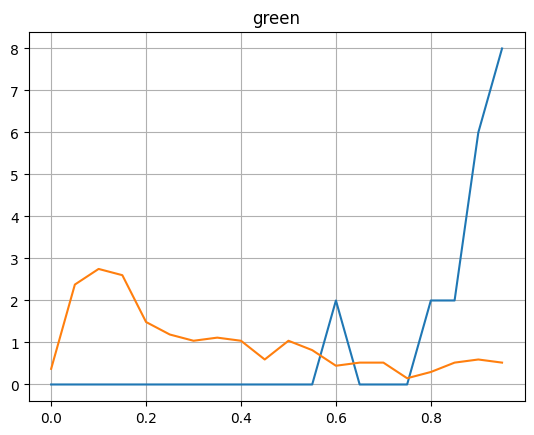

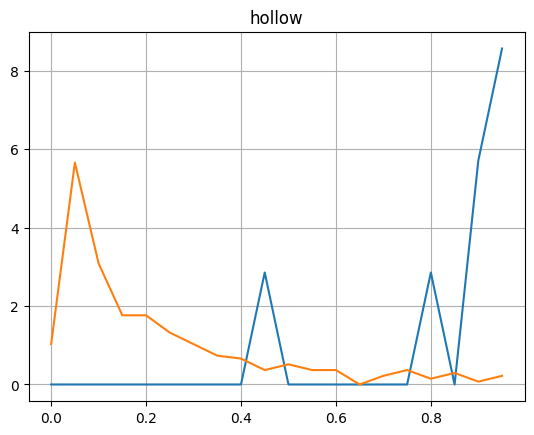

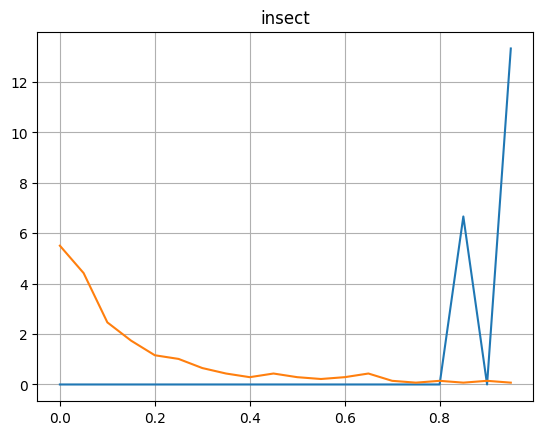

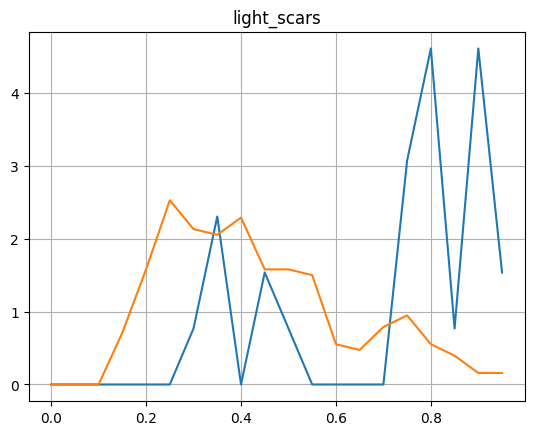

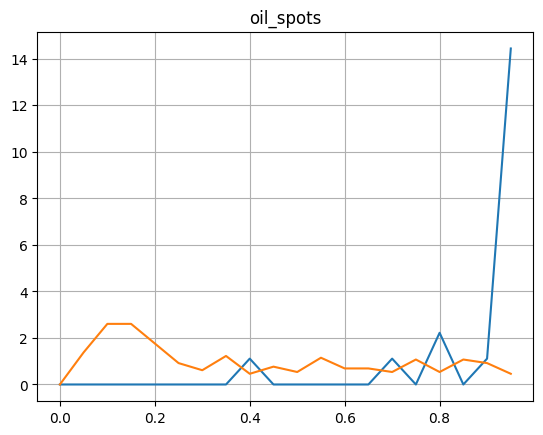

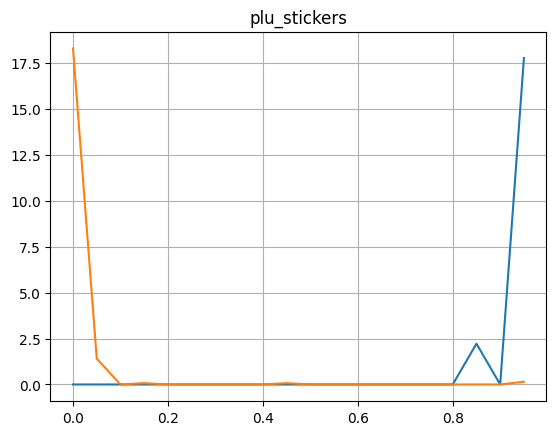

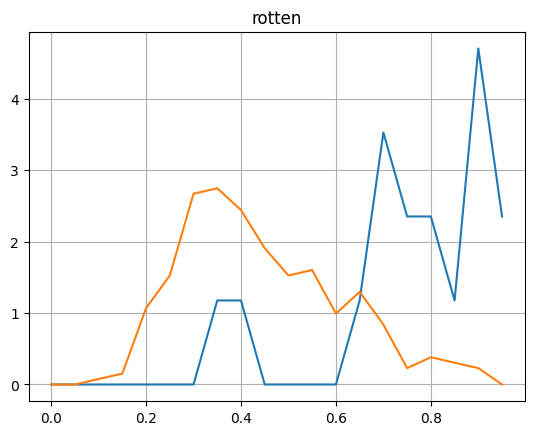

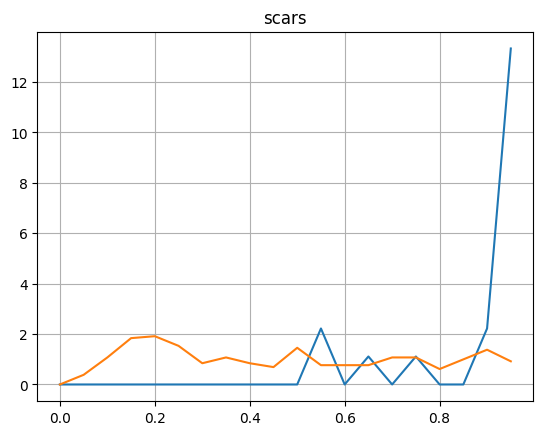

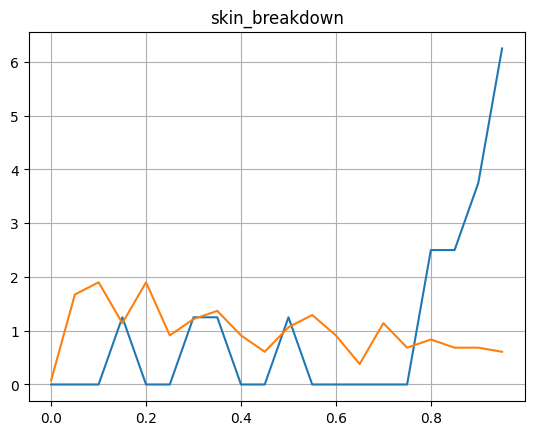

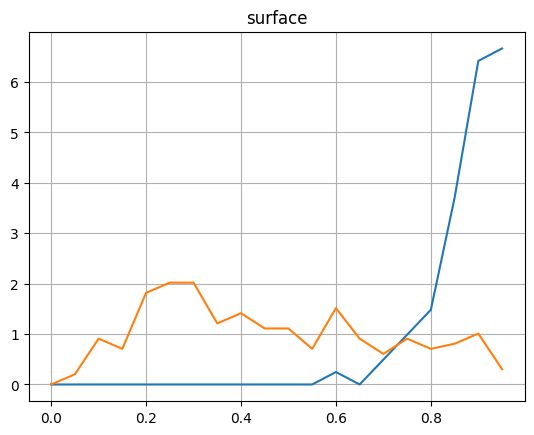

In [8]:
for id_clase in range(len(clases)):
    prob=preds_val[:,id_clase]
    t=labels_val[:,id_clase]

    target_pos=t[t>0.5]
    pred_pos=prob[t>0.5]

    target_neg=t[t<0.5]
    pred_neg=prob[t<0.5]

    
    hh=np.ones(1)/1
    hpos,e=np.histogram(pred_pos,bins=20,range=(0.0,1.0),density=True)
    hneg,f=np.histogram(pred_neg,bins=20,range=(0.0,1.0),density=True)
    
    hpos=np.convolve(hpos, hh, 'same')
    hneg=np.convolve(hneg, hh, 'same')
    _=plt.figure()
    _=plt.plot(e[:-1],hpos)
    _=plt.plot(f[:-1],hneg)
    _=plt.title(clases[id_clase])
    _=plt.grid()

# Casos con más error de validación

In [45]:
print(len(filenames_val))

falsas_alarmas={}
no_detectadas={}
for id_clase in range(len(clases)):
    falsas_alarmas[clases[id_clase]]=[]
    no_detectadas[clases[id_clase]]=[]

    print("CLASE ",clases[id_clase])
    prob=preds_val[:,id_clase]
    t=labels_val[:,id_clase]
    idx_neg=np.argwhere(t<0.5)
    idx_pos=np.argwhere(t>0.5)
    idx_neg=idx_neg.squeeze()
    idx_pos=idx_pos.squeeze()

    probpos=prob[idx_pos].squeeze()
    probneg=prob[idx_neg].squeeze()

 
    print(f'Negativos :{len(idx_neg)} Positivos={len(idx_pos)}')
    print(probpos.shape,probneg.shape)

    sorted_neg_idx=np.argsort(probneg)
    sorted_pos_idx=np.argsort(probpos)

    print("FALSAS ALARMAS ",clases[id_clase])
    for n in sorted_neg_idx[-5:]:
        #print(n)
        idx=idx_neg[n].item()
        print(f"{clases[id_clase]}:{prob[idx].item():.2f}:label={t[idx].item()}:{filenames_val[idx].replace("npz","png")}")
        falsas_alarmas[clases[id_clase]].append((filenames_val[idx].replace("npz","png"),int(100*prob[idx].item())))
    print("NODET ",clases[id_clase])        
    for n in sorted_pos_idx[:3]:
        #print(n)
        idx=idx_pos[n].item()
        print(f"{clases[id_clase]}:{prob[idx].item():.2f}:label={t[idx].item()}:{filenames_val[idx].replace("npz","png")}")        
        no_detectadas[clases[id_clase]].append((filenames_val[idx].replace("npz","png"),int(100*prob[idx].item())))


279
CLASE  green
Negativos :269 Positivos=10
torch.Size([10]) torch.Size([269])
FALSAS ALARMAS  green
green:0.97:label=0:data/mandarins/nardocot/manfredi/20250220_1239_000137.png
green:0.98:label=0:data/mandarins/nardocot/manfredi/20250220_1239_002142.png
green:0.98:label=0:data/mandarins/nardocot/manfredi/20250220_1240_002158.png
green:0.99:label=0:data/mandarins/clementine/KDC/20220803_230825_CLEMENTINE_Encoder_Geens/20250217_1651_002016.png
green:0.99:label=0:data/mandarins/nardocot/manfredi/20250220_1240_000143.png
NODET  green
green:0.64:label=1:data/mandarins/nardocot/manfredi/20250220_1248_002200.png
green:0.81:label=1:data/mandarins/tango/KDC/20220805_172517_tango_PROD/20250218_1157_000592.png
green:0.86:label=1:data/mandarins/tango/KDC/20220805_180026_tangoPROD/20250218_1201_000653.png
CLASE  hollow
Negativos :272 Positivos=7
torch.Size([7]) torch.Size([272])
FALSAS ALARMAS  hollow
hollow:0.89:label=0:data/oranges/navel/KDC/20220810_022231_Encoder_decay/20250218_1100_000435.pn

In [46]:
no_detectadas

{'green': [('data/mandarins/nardocot/manfredi/20250220_1248_002200.png', 64),
  ('data/mandarins/tango/KDC/20220805_172517_tango_PROD/20250218_1157_000592.png',
   80),
  ('data/mandarins/tango/KDC/20220805_180026_tangoPROD/20250218_1201_000653.png',
   85)],
 'hollow': [('data/mandarins/tango/KDC/20220806_185859_tango_ENCODER_ROTAS/20250218_1000_000338.png',
   45),
  ('data/mandarins/clementine/KDC/20220804_221439_CLEMENTINE_ENCODER_Hollow/20250218_1113_000470.png',
   84),
  ('data/mandarins/nardocot/manfredi/20250220_1112_002037.png', 90)],
 'insect': [('data/mandarins/nardocot/manfredi/20250220_1244_002174.png', 86),
  ('data/mandarins/nardocot/manfredi/20250220_1245_002193.png', 98),
  ('data/mandarins/nardocot/manfredi/20250220_1245_002189.png', 99)],
 'light_scars': [('data/mandarins/clementine/KDC/20220808_154219_Img_20220808_154156produccionClementina/20250218_1148_000546.png',
   32),
  ('data/oranges/navel/manfredi/20250224_0910_000137.png', 35),
  ('data/oranges/navel/manf

In [47]:
# Guardar en jsosns falsas alarmas y no detectadas
falsas_alarmas_json="../out_evaluate_patch/falsas_alarmas.json"
no_detectadas_json="../out_evaluate_patch/no_detectadas.json"
falsas_alarmas_json=os.path.join(current_file_dir,falsas_alarmas_json)
no_detectadas_json=os.path.join(current_file_dir,no_detectadas_json)
with open(falsas_alarmas_json, 'w') as fp:
    json.dump(falsas_alarmas, fp,indent=3)
with open(no_detectadas_json, 'w') as fp:
    json.dump(no_detectadas, fp,indent=3)